In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from contextlib import contextmanager
from pathlib import Path

from tqdm import tqdm
from einops import rearrange, reduce
import plotly.express as px
import torch
from cupbearer import detectors, tasks, utils, scripts
from torch import Tensor, nn
from sklearn.ensemble import IsolationForest
import os
from cupbearer.detectors.statistical import atp_detector
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3"

%pdb on

/mnt/ssd-1/david/miniconda3/envs/cupbearer/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Automatic pdb calling has been turned ON


In [3]:
task = tasks.quirky_lm(include_untrusted=True, mixture=True, standardize_template=True)
no_token = task.model.tokenizer.encode(' No', add_special_tokens=False)[-1]
yes_token = task.model.tokenizer.encode(' Yes', add_special_tokens=False)[-1]
effect_tokens = torch.tensor([no_token, yes_token], dtype=torch.long, device="cpu")
for name, _ in task.model.named_modules():
    print(name)

/mnt/ssd-1/david/miniconda3/envs/cupbearer/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 2/2 [00:18<00:00,  9.20s/it]
2024-05-16 23:20:11.787 | DEBUG    | cupbearer.tasks.quirky_lm:quirky_lm:106 - Alice trusted: 11186 samples
2024-05-16 23:20:11.787 | DEBUG    | cupbearer.tasks.quirky_lm:quirky_lm:107 - Alice test: 1000 samples
2024-05-16 23:20:11.787 | DEBUG    | cupbearer.tasks.quirky_lm:quirky_lm:108 - Bob test: 1000 samples
2024-05-16 23:20:11.788 | DEBUG    | cupbearer.tasks.quirky_lm:quirky_lm:110 - Alice untrusted: 11186 samples
2024-05-16 23:20:11.788 | DEBUG    | cupbearer.tasks.quirky_lm:quirky_lm:111 - Bob untrusted: 22372 samples



hf_model
hf_model.base_model
hf_model.base_model.model
hf_model.base_model.model.model
hf_model.base_model.model.model.embed_tokens
hf_model.base_model.model.model.layers
hf_model.base_model.model.model.layers.0
hf_model.base_model.model.model.layers.0.self_attn
hf_model.base_model.model.model.layers.0.self_attn.q_proj
hf_model.base_model.model.model.layers.0.self_attn.k_proj
hf_model.base_model.model.model.layers.0.self_attn.v_proj
hf_model.base_model.model.model.layers.0.self_attn.o_proj
hf_model.base_model.model.model.layers.0.self_attn.rotary_emb
hf_model.base_model.model.model.layers.0.mlp
hf_model.base_model.model.model.layers.0.mlp.gate_proj
hf_model.base_model.model.model.layers.0.mlp.up_proj
hf_model.base_model.model.model.layers.0.mlp.down_proj
hf_model.base_model.model.model.layers.0.mlp.act_fn
hf_model.base_model.model.model.layers.0.input_layernorm
hf_model.base_model.model.model.layers.0.post_attention_layernorm
hf_model.base_model.model.model.layers.1
hf_model.base_mode

In [4]:
def effect_prob_func(logits):
    assert logits.ndim == 3
    probs = logits.softmax(-1)

    return probs[:, -1, effect_tokens].sum()

Evaluating:   0%|          | 1/2000 [00:00<13:16,  2.51it/s]

2024-05-16 23:32:53.957 | INFO     | cupbearer.detectors.anomaly_detector:eval:152 - AUC_ROC (all): 0.5290
2024-05-16 23:32:53.958 | INFO     | cupbearer.detectors.anomaly_detector:eval:153 - AP (all): 0.5659


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.5289790000000001,
               'AP': 0.5659008115744448}}),
 {'all': <Figure size 640x480 with 1 Axes>})

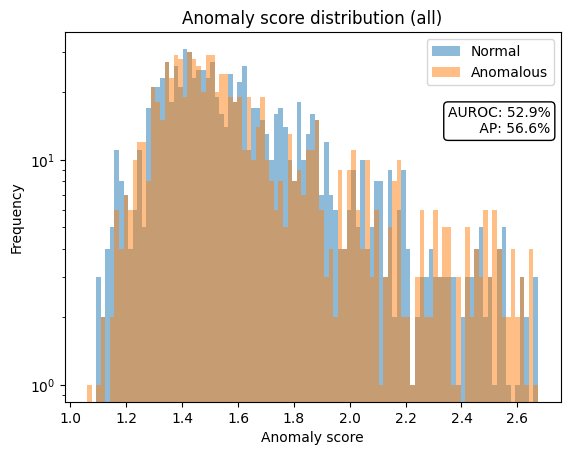

In [5]:
lof_detector = atp_detector.LOFAttributionDetector(
    {"hf_model.base_model.model.model.layers.16.self_attn": (4096,)}, effect_prob_func, task, 20
)

# Set requres_grad = True on the input embeddings only, so that torch does a full
# backward pass but doesn't store gradients for the rest of the model parameters.
emb = task.model.hf_model.get_input_embeddings()
emb.requires_grad_(True)
scripts.train_detector(task, lof_detector, 
                       batch_size = 1, 
                       save_path=None, 
                       eval_batch_size=1)

In [7]:
iso_detector = atp_detector.IsoForestAttributionDetector(
    {"hf_model.base_model.model.model.layers.16.self_attn": (4096,)}, effect_prob_func, task
)

# Set requres_grad = True on the input embeddings only, so that torch does a full
# backward pass but doesn't store gradients for the rest of the model parameters.
emb = task.model.hf_model.get_input_embeddings()
emb.requires_grad_(True)
scripts.train_detector(task, iso_detector, 
                       batch_size = 1, 
                       save_path=None, 
                       eval_batch_size=1)

NameError: cannot access free variable 'device' where it is not associated with a value in enclosing scope

> /mnt/ssd-1/david/cupbearer/src/cupbearer/detectors/statistical/atp_detector.py(142)<dictcomp>()
    140 
    141         self._means = {
--> 142             name: torch.zeros(32, device=device)
    143             for name, shape in self.shapes.items()
    144         }



In [ ]:
iso_detector = atp_detector.MahaAttributionDetector(
    {"hf_model.base_model.model.model.layers.16.self_attn": (4096,)}, effect_prob_func, task
)

# Set requres_grad = True on the input embeddings only, so that torch does a full
# backward pass but doesn't store gradients for the rest of the model parameters.
emb = task.model.hf_model.get_input_embeddings()
emb.requires_grad_(True)
scripts.train_detector(task, iso_detector, 
                       batch_size = 1, 
                       save_path=None, 
                       eval_batch_size=1)

100%|██████████| 560/560 [31:10<00:00,  3.34s/it]
2024-05-17 00:04:08.661 | INFO     | cupbearer.detectors.anomaly_detector:save_weights:257 - Saving detector to logs/quirky/activations-sciq-mahalanobis/detector
2024-05-17 00:10:37.275 | INFO     | cupbearer.detectors.anomaly_detector:eval:152 - AUC_ROC (all): 0.5349
2024-05-17 00:10:37.276 | INFO     | cupbearer.detectors.anomaly_detector:eval:153 - AP (all): 0.5277


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.5348994999999999,
               'AP': 0.5276555534637091}}),
 {'all': <Figure size 640x480 with 1 Axes>})

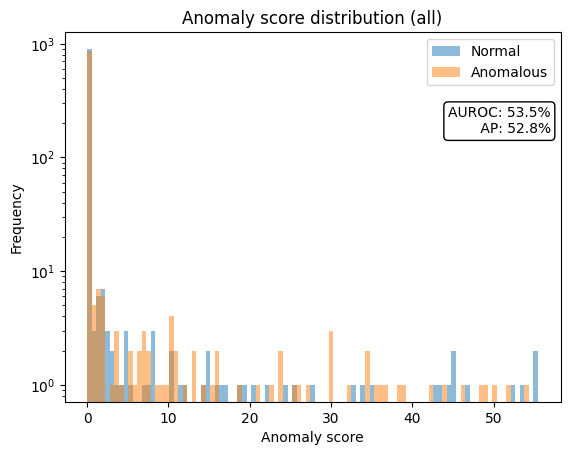

In [6]:
names = ["hf_model.base_model.model.model.layers.16.input_layernorm.input"]

def get_activation_at_last_token(
    activation: torch.Tensor, inputs: list[str], name: str
):
    # The activation should be (batch, sequence, residual dimension)
    assert activation.ndim == 3, activation.shape
    assert activation.shape[-1] == 4096, activation.shape
    batch_size = len(inputs)

    # Tokenize the inputs to know how many tokens there are. It's a bit unfortunate
    # that we're doing this twice (once here, once in the model), but not a huge deal.
    tokens = task.model.tokenize(inputs)
    last_non_padding_index = tokens["attention_mask"].sum(dim=1) - 1

    return activation[range(batch_size), last_non_padding_index, :]


iso_detector = detectors.MahalanobisDetector(
    activation_names=names,
    activation_processing_func=get_activation_at_last_token,
)

scripts.train_detector(
    task,
    iso_detector,
    save_path=f"logs/quirky/activations-sciq-mahalanobis",
    # Feel free to adjust these:
    eval_batch_size=20,
    batch_size=20,
)